<a href="https://colab.research.google.com/github/Jad-yehya/M2-RLD/blob/main/03_2_dqn_full_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlook

In this notebook, using BBRL, we code a version of the DQN algorithm with a
replay buffer and a target network, using the AutoReset approach.

To understand this code, you need to know more about
[the BBRL interaction model](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing).
Then you should run [a first example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
to see how agents interact.

You also need to understand [details about
autoreset=True](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing).

The DQN algorithm is explained in [this
video](https://www.youtube.com/watch?v=CXwvOMJujZk) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/dqn.pdf).

In this notebook, you will learn how to modify the previous notebook:

- to use a replay buffer and an environment that resets
- to use a target network for $Q$
- to use a better estimation for the maximum (Double-DQN)

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

We use OmegaConf to that makes it possible that by just defining the `def
run_dqn(cfg):` function and then executing a long `params = {...}` variable at
the bottom of this colab, the code is run with the parameters without calling
an explicit main.

More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_dqn(config)`

at the very bottom of the colab, after starting tensorboard.

Below, we import standard python packages, pytorch packages and gymnasium
environments.

In [ ]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install easypip")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl>=0.2.2
[easypip] Installing swig
[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing box2d-kengz


In [ ]:
import os
import sys
from pathlib import Path
import math

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime
OmegaConf.register_new_resolver(
    "current_time", lambda: strftime("%Y%m%d-%H%M%S"), replace=True
)

## BBRL imports

In [ ]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace,
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ...
#
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

In [ ]:
# This is a utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [ ]:
from bbrl import get_arguments, get_class
from itertools import chain

def setup_optimizer(cfg_optimizer, *agents):
    """Setup an optimizer for a list of agents"""
    optimizer_args = get_arguments(cfg_optimizer)
    parameters = [agent.parameters() for agent in agents]
    optimizer = get_class(cfg_optimizer)(chain(*parameters), **optimizer_args)
    return optimizer

def copy_parameters(model_a, model_b):
    """Copy parameters from a model a to model_b"""
    for model_a_p, model_b_p in zip(model_a.parameters(), model_b.parameters()):
        model_b_p.data.copy_(model_a_p)

### The Logger class

The logger is in charge of collecting statistics during the training
process.

Having logging provided under the hood is one of the features allowing you
to save time when using RL libraries like BBRL.

In these notebooks, the logger is defined as `bbrl.utils.logger.TFLogger` so as
to use a tensorboard visualisation (see the parameters part `params = { "logger":{ ...` below).

Note that the BBRL Logger is also saving the log in a readable format such
that you can use `Logger.read_directories(...)` to read multiple logs, create
a dataframe, and analyze many experiments afterward in a notebook for
instance. The code for the different kinds of loggers is available in the
[bbrl/utils/logger.py](https://github.com/osigaud/bbrl/blob/master/src/bbrl/utils/logger.py)
file.

`instantiate_class` is an inner BBRL mechanism. The
`instantiate_class`function is available in the
[`bbrl/__init__.py`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/__init__.py)
file.

In [ ]:
from bbrl import instantiate_class

class Logger():

    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, steps):
        self.logger.add_scalar(log_string, loss.item(), steps)

    # A specific function for RL algorithms having a critic, an actor and an entropy losses
    def log_losses(self, critic_loss, entropy_loss, actor_loss, steps):
        self.add_log("critic_loss", critic_loss, steps)
        self.add_log("entropy_loss", entropy_loss, steps)
        self.add_log("actor_loss", actor_loss, steps)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

In [ ]:
import numpy as np
from typing import Any
import logging
from abc import ABC, abstractmethod
from functools import cached_property

class RLBase(ABC):
    """Base class for Reinforcement learning algorithms

    This class deals with common processing:

    - defines the logger, the train and evaluation agents
    - defines how to evaluate a policy
    """

    #: The configuration
    cfg: Any

    #: The evaluation environment deals with the last action, and produces a new
    # state of the environment
    eval_env: Agent

    #: The training policy
    train_policy: Agent

    #: The evaluation policy (if not defined, uses the train policy)
    eval_policy: Agent

    def __init__(self, cfg):
        # Basic initialization
        self.cfg = cfg
        torch.manual_seed(cfg.algorithm.seed)

        # Initialize the logger class
        self.logger = Logger(cfg)

        # Subclasses have to define the train policy
        self.train_policy = None

        # Sets up the evaluation environment
        self.eval_env = ParallelGymAgent(
            partial(make_env, cfg.gym_env.env_name),
            cfg.algorithm.nb_evals
        ).seed(cfg.algorithm.seed)
        self.eval_policy = None

        # Initialize values
        self.last_eval_step = 0
        self.nb_steps = 0
        self.best_policy = None
        self.best_reward = -torch.inf

        # Records the rewards
        self.base_dir = Path(self.cfg.base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)

        self.eval_rewards = []

    @cached_property
    def train_agent(self):
        """Returns the train agent"""
        assert self.train_policy is not None, "eval_agent property is not defined before the policy is set"
        return TemporalAgent(Agents(self.train_env, self.train_policy))

    @cached_property
    def eval_agent(self):
        """Returns the evaluation agent"""
        assert self.eval_policy is not None or self.train_policy is not None, "eval_agent property is not defined before the policy is set"
        return TemporalAgent(Agents(self.eval_env, self.eval_policy if self.eval_policy is not None else self.train_policy))

    def post_run(self):
        """Post-processing after learning has taken place"""
        if self.cfg.collect_stats and self.eval_rewards:
            data = torch.stack(self.eval_rewards, axis=-1)
            with (self.base_dir / "stats").open("wt") as fp:
                np.savetxt(fp, data.numpy())

    def evaluate(self):
        """Evaluate the current policy

        Evaluation is conducted every `cfg.algorithm.eval_interval` steps, and
        we keep a copy of the best agent so far in `self.best_policy`"""
        if (self.nb_steps - self.last_eval_step) > self.cfg.algorithm.eval_interval:
            self.last_eval_step = self.nb_steps
            eval_workspace = Workspace()
            self.eval_agent(
                eval_workspace,
                t=0,
                stop_variable="env/done"
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            self.logger.log_reward_losses(rewards, self.nb_steps)

            if self.cfg.collect_stats:
                self.eval_rewards.append(rewards)

            rewards_mean = rewards.mean()
            if rewards_mean > self.best_reward:
                self.best_policy = copy.deepcopy(self.eval_policy)
                self.best_reward = rewards_mean


    def visualize_best(self):
        """Visualize the best agent"""
        env = make_env(self.cfg.gym_env.env_name, render_mode="rgb_array")
        path = self.base_dir / "best_agent.mp4"
        print(f"Video of best agent recorded in {path}")
        record_video(env, self.best_policy, path)
        return video_display(str(path.absolute()))

    @abstractmethod
    def run(self):
        ...

In [ ]:
class RLTransitions(RLBase):
    """RL with transition buffer"""

    train_agent: TemporalAgent

    """Base class for RL experiments with full episodes"""
    def __init__(self, cfg):
        super().__init__(cfg)

        # We use a non-autoreset workspace
        self.train_env = ParallelGymAgent(
            partial(make_env, cfg.gym_env.env_name, autoreset=True),
            cfg.algorithm.n_envs
        ).seed(cfg.algorithm.seed)

        # Configure the workspace to the right dimension
        # Note that no parameter is needed to create the workspace.
        self.replay_buffer = ReplayBuffer(max_size=cfg.algorithm.buffer_size)


    def run(self):
        """Run with transition buffer"""
        train_workspace = Workspace()

        epochs_pb = tqdm(range(self.cfg.algorithm.max_epochs))
        for epoch in epochs_pb:
            # Execute the agent in the workspace
            if epoch > 0:
                train_workspace.zero_grad()
                train_workspace.copy_n_last_steps(1)
                self.train_agent(
                    train_workspace, t=1, n_steps=self.cfg.algorithm.n_steps-1, stochastic=True
                )
            else:
                self.train_agent(
                    train_workspace, t=0, n_steps=self.cfg.algorithm.n_steps, stochastic=True
                )

            self.nb_steps += self.cfg.algorithm.n_steps * self.cfg.algorithm.n_envs

            # Add transitions to buffer
            transition_workspace = train_workspace.get_transitions()
            self.replay_buffer.put(transition_workspace)
            if self.replay_buffer.size() > self.cfg.algorithm.learning_starts:
                self.learning_step(self.replay_buffer)

            # Evaluate if enough steps have been performed
            self.evaluate()

            # Eval
            epochs_pb.set_description(
                f"nb_steps: {self.nb_steps}, "
                f"best reward: {self.best_reward:.2f}"
            )

        self.post_run()
        return self

As before, we start with a Random Agent and 3 instances of the CartPole environment

In [ ]:
# We deal with 3 running episodes at a time (random seed 2139)

env_agent = ParallelGymAgent(partial(make_env, env_name='CartPole-v1'), 3).seed(2139)
obs_size, action_dim = env_agent.get_obs_and_actions_sizes()
print(f"Environment: observation space in R^{obs_size} and action space R^{action_dim}")

class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)

# Each agent will be run (in the order given when constructing Agents)
agents = Agents(env_agent, RandomAgent(action_dim))
t_agents = TemporalAgent(agents)

Environment: observation space in R^4 and action space R^2


Let us have a closer look at the content of the workspace

In [ ]:
# Creates a new workspace
workspace = Workspace()
t_agents(workspace, stop_variable="env/done")

# We get the transitions: each tensor is transformed so
# that:
# - we have the value at time step t and t+1 (so all the tensors first dimension have a size of 2)
# - there is no distinction between the different environments (here, there is just one environment run in parallel to make it easy)
transitions = workspace.get_transitions()

# You can see that each pair of actions in the transitions can be found in the workspace
display("Observations (first 3)", workspace["env/env_obs"][:3, 0])

display("Transitions of actions (first 3)")
for t in range(3):
    display(f'(s_{t}, s_{t+1})')
    display(transitions["env/env_obs"][:, t])

'Observations (first 3)'

tensor([[-0.0085, -0.0427, -0.0489,  0.0215],
        [-0.0094, -0.2371, -0.0485,  0.2984],
        [-0.0141, -0.0413, -0.0425, -0.0092]])

'Transitions of actions (first 3)'

'(s_0, s_1)'

tensor([[-0.0085, -0.0427, -0.0489,  0.0215],
        [-0.0094, -0.2371, -0.0485,  0.2984]])

'(s_1, s_2)'

tensor([[ 0.0005,  0.0025, -0.0493, -0.0402],
        [ 0.0006, -0.1919, -0.0501,  0.2366]])

'(s_2, s_3)'

tensor([[ 0.0080,  0.0203, -0.0023, -0.0085],
        [ 0.0084,  0.2155, -0.0025, -0.3019]])

## The replay buffer

Differently from the previous case, we use a replace buffer that stores the a
set of transitions $(s_t, a_t, r_t, s_{t+1})$
Finally, the replay buffer keeps slices [:, i, ...] of the transition
workspace (here at most 100 transitions)

In [ ]:
rb = ReplayBuffer(max_size=100)

# We add the transitions to the buffer....
rb.put(transitions)

# And sample from them here we get 3 tuples (s_t, s_{t+1})
rb.get_shuffled(3)["env/env_obs"]

tensor([[[-0.0259, -0.6233, -0.0346,  0.7955],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1967, -0.0555,  0.2057,  0.3101]],

        [[-0.0384, -0.8180, -0.0187,  1.0771],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1978, -0.2529,  0.2119,  0.6599]]])

A transition workspace is still a workspace... this is quite
 handy since each transition can be seen as a mini-episode of two time steps;
 we can use our agents on it:

In [ ]:
# Just as a reference

display(transitions["action"])

t_random_agent = TemporalAgent(RandomAgent(action_dim))
t_random_agent(transitions, t=0, n_steps=2)

# Here, the action tensor will have been overwritten by the new actions
display(transitions["action"])

tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
         1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
         0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
         0, 1, 0, 0]])

tensor([[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
         0, 0, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         1, 0, 1, 1]])

## Definition of agents

### The critic agent

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only
algorithm. Thus we just need a Critic agent (which will also be used to output
actions) and an Environment agent. We reuse the `DiscreteQAgent` class that we
have already explained in the previous notebook.

The function below builds a multi-layer perceptron where the size of each layer is given in the `size` list.
We also specify the activation function of neurons at each layer and optionally a different activation function for the final layer.

In [ ]:
import torch.nn as nn
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)

    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

In [ ]:
class DiscreteQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        q_values = self.model(obs)
        self.set((f"{self.prefix}q_values", t), q_values)

class ArgmaxActionSelector(Agent):
    """BBRL agent that selects the best action based on Q(s,a)"""
    def forward(self, t: int, **kwargs):
        q_values = self.get(("q_values", t))
        action = q_values.argmax(1)
        self.set(("action", t), action)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence.
Here we will use the simple $\epsilon$-greedy exploration method. The method
is implemented as an agent which chooses an action based on the Q-values.

In [ ]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t, **kwargs):
        q_values = self.get(("q_values", t))
        nb_actions = q_values.size()[1]
        size = q_values.size()[0]
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]
        action = is_random * random_action + (1 - is_random) * max_action
        action = action.long()
        self.set(("action", t), action)

### Training and evaluation environments

We build two environments: one for training and another one for evaluation.

For training, it is more efficient to use an autoreset agent, as we do not
want to waste time if the task is done in an environment sooner than in the
others.

By contrast, for evaluation, we just need to perform a fixed number of
episodes (for statistics), thus it is more convenient to use a
noautoreset agent with a set of environments and just run one episode in
each environment. Thus we can use the `env/done` stop variable and take the
average over the cumulated reward of all environments.

See [this
notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
for explanations about agents and environment agents.

In [ ]:
from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

def get_env_agents(cfg, *, autoreset=True, include_last_state=True) -> Tuple[GymAgent, GymAgent]:
    # Returns a pair of environments (train / evaluation) based on a configuration `cfg`

    # Train environment
    train_env_agent = ParallelGymAgent(
        partial(make_env, cfg.gym_env.env_name, autoreset=autoreset),
        cfg.algorithm.n_envs,
        include_last_state=include_last_state
    ).seed(cfg.algorithm.seed)

    # Test environment
    eval_env_agent = ParallelGymAgent(
        partial(make_env, cfg.gym_env.env_name),
        cfg.algorithm.nb_evals,
        include_last_state=include_last_state
    ).seed(cfg.algorithm.seed)

    return train_env_agent, eval_env_agent

### Setup the optimizers

We use a single optimizer to tune the parameters of the actor (in the
prob_agent part) and the critic (in the critic_agent part). It would be
possible to have two optimizers which would work separately on the parameters
of each component agent, but it would be more complicated because updating the
actor requires the gradient of the critic.

In [ ]:
# Configure the optimizer over the q agent
def setup_optimizers(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

## Main training loop

Note that everything about the shared workspace between all the agents is
completely hidden under the hood. This results in a gain of productivity, at
the expense of having to dig into the BBRL code if you want to understand the
details, change the multiprocessing model, etc.

### Agent execution

This is the tricky part with BBRL, the one we need to understand in detail.
The difficulty lies in the copy of the last step and the way to deal with the
n_steps return.

The call to `train_agent(workspace, t=1, n_steps=cfg.algorithm.n_timesteps -
1, stochastic=True)` makes the agent run a number of steps in the workspace.
In practice, it calls the
[`__call__(...)`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/agents/agent.py#L59)
function which makes a forward pass of the agent network using the workspace
data and updates the workspace accordingly.

Now, if we start at the first epoch (`epoch=0`), we start from the first step
(`t=0`). But when subsequently we perform the next epochs (`epoch>0`), we must
not forget to cover the transition at the border between the previous epoch
and the current epoch. To avoid this risk, we copy the information from the
last time step of the previous epoch into the first time step of the next
epoch.

Note that we `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`
lines. `optimizer.zero_grad()` is necessary to cancel all the gradients
computed at the previous iterations

In [ ]:
class DQNBase(RLTransitions):
    def __init__(self, cfg):
        super().__init__(cfg)

        train_env_agent, eval_env_agent = get_env_agents(cfg)
        obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

        # Get the two agents (critic and target critic)
        critic = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)
        target_critic = copy.deepcopy(critic).with_prefix("target/")

        # Builds the train agent that will produce transitions
        explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
        self.train_policy = Agents(critic, explorer)

        self.eval_policy = Agents(critic, ArgmaxActionSelector())

        # Creates two temporal agents just for "replaying" some parts
        # of the transition buffer
        self.q_agent = TemporalAgent(critic)
        self.target_q_agent = TemporalAgent(target_critic)

        # Get an agent that is executed on a complete workspace
        self.optimizer = setup_optimizers(cfg, self.q_agent)

        self.last_critic_update_step = 0

    @abstractmethod
    def compute_critic_loss(self, reward, must_bootstrap, q_values, target_q_values, action):
        """Compute the critic loss

        :param reward: The reward $r_t$ (shape 2 x B)
        :param must_bootstrap: The must bootstrap flag at $t+1$ (shape 2 x B)
        :param q_values: The Q-values (shape 2 x B x A)
        :param target_q_values: The target Q-values (shape 2 x B x A)
        :param action: The chosen actions (shape 2 x B)
        :return: the loss (a scalar)
        """
        ...


    def learning_step(self, rb):
        for _ in range(self.cfg.algorithm.n_updates):
            rb_workspace = rb.get_shuffled(self.cfg.algorithm.batch_size)

            # The q agent needs to be executed on the rb_workspace workspace
            self.q_agent(rb_workspace, t=0, n_steps=2, choose_action=False)
            with torch.no_grad():
                self.target_q_agent(rb_workspace, t=0, n_steps=2, stochastic=True)

            q_values, terminated, reward, action, target_q_values = rb_workspace[
                "q_values", "env/terminated", "env/reward", "action", "target/q_values"
            ]

            # Determines whether values of the critic should be propagated
            must_bootstrap = ~terminated

            # Compute critic loss
            critic_loss = self.compute_critic_loss(
                reward, must_bootstrap, q_values, target_q_values, action
            )
            # Store the loss for tensorboard display
            self.logger.add_log("critic_loss", critic_loss, self.nb_steps)

            self.optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_agent.parameters(), self.cfg.algorithm.max_grad_norm)
            self.optimizer.step()

            # Update target
            if self.nb_steps - self.last_critic_update_step > self.cfg.algorithm.target_critic_update:
                self.last_critic_update_step = self.nb_steps
                copy_parameters(self.q_agent, self.target_q_agent)

### Compute critic loss

Detailed explanations of the function to compute the critic loss when using
`autoreset=False` are given in [this
notebook](http://master-dac.isir.upmc.fr/rld/rl/03-1-dqn-introduction.student.ipynb).
The case where we use `autoreset=True` is very similar, but we need to
specify that we use the first part of the Q-values (`q_values[0]`) for
representing $Q(s_t,a_t)$ and the second part (`q_values[1]`) for representing
$Q(s_{t+1},a)$, as these values are stored into a transition model.

In [ ]:
class DQN(DQNBase):
    def compute_critic_loss(self, reward, must_bootstrap, q_values, target_q_values, action):
        """Compute the critic loss

        :param reward: The reward $r_t$ (shape 2 x B)
        :param must_bootstrap: The must bootstrap flag at $t+1$ (shape 2 x B)
        :param q_values: The Q-values (shape 2 x B x A)
        :param target_q_values: The target Q-values (shape 2 x B x A)
        :param action: The chosen actions (shape 2 x B)
        :return: _description_
        """

        # Implement the DQN loss

        # Adapt from the previous notebook and adapt to our case (target Q network)
        # Don't forget that we deal with transitions (and not episodes)
        target = reward[1:] + self.cfg.algorithm.discount_factor * must_bootstrap[1:] * target_q_values.max(2)[1].detach()[1:]
        qvals = q_values.gather(2, action.unsqueeze(-1)).squeeze(-1)[:-1]

        # critic_loss = ((q_vals - q_goal).pow(2) * must_bootstrap[:-1]).mean()


        # Compute critic loss (no need to use must_bootstrap here since we are dealing with "full" transitions)
        mse = nn.MSELoss()
        critic_loss = mse(target, qvals)
        return critic_loss

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

### Launching tensorboard to visualize the results

In [ ]:
setup_tensorboard("./outputs/tblogs")

<IPython.core.display.Javascript object>

In [ ]:
params={
  "base_dir": "./outputs/stats/${gym_env.env_name}/dqn-S${algorithm.seed}_${current_time:}",
  "collect_stats": True,
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./outputs/tblogs/${gym_env.env_name}/dqn-S${algorithm.seed}_${current_time:}",
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,
    },

  "algorithm":{
    "seed": 4,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 3_000,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

dqn = DQN(OmegaConf.create(params))
dqn.run()
dqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

Video of best agent recorded in outputs/stats/CartPole-v1/dqn-S4_20231002-151609/best_agent.mp4
Moviepy - Building video /content/outputs/stats/CartPole-v1/dqn-S4_20231002-151609/best_agent.mp4.
Moviepy - Writing video /content/outputs/stats/CartPole-v1/dqn-S4_20231002-151609/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /content/outputs/stats/CartPole-v1/dqn-S4_20231002-151609/best_agent.mp4


## Coding Exercise: Double DQN (DDQN)

In DQN, the same network is responsible for selecting and estimating the best
next action (in the TD-target) and that may lead to over-estimation: the
action which q-value is over-estimated will be chosen more often. As a result,
training is slower.

To reduce over-estimation, double q-learning (and then DDQN) was proposed. It
decouples the action selection from the value estimation.

Concretely, in DQN, the target value in the critic loss (used to update the Q
critic) for a sample at time $t$ is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1},
a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `target_q_agent` with parameters
$\mathbb{\theta}_{target}$ is used for both action selection and estimation,
and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a;
\mathbb{\theta}_{target}\right)$$

Instead, DDQN uses the online critic `q_agent` with parameters
$\mathbb{\theta}_{online}$ to select the action, whereas it uses the target
network `target_q_agent` to estimate the associated Q-values:

$$Y^{DDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1},
a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$

The goal in this exercise is for you to write the update method for `DDQN`.

In [ ]:
class DoubleDQN(DQNBase):
    def compute_critic_loss(self, reward, must_bootstrap, q_values, target_q_values, action):
        """Compute the critic loss

        :param reward: The reward $r_t$ (shape 2 x B)
        :param must_bootstrap: The must bootstrap flag at $t+1$ (shape 2 x B)
        :param q_values: The Q-values (shape 2 x B x A)
        :param target_q_values: The target Q-values (shape 2 x B x A)
        :param action: The chosen actions (shape 2 x B)
        :return: the loss (a scalar)
        """

        # Implement the double DQN loss
        actions = torch.argmax(q_values, 2).detach()[1:]
        target = reward[1:] + self.cfg.algorithm.discount_factor * must_bootstrap[1:] * target_q_values[:, :, actions]
        qvals = q_values.gather(2, action.unsqueeze(-1)).squeeze(-1)[:-1]



        # Compute critic loss
        mse = nn.MSELoss()
        critic_loss = mse(target, qvals)
        return critic_loss

In [ ]:
params={
  "base_dir": "./outputs/stats/${gym_env.env_name}/double-dqn-S${algorithm.seed}_${current_time:}",
  "collect_stats": True,
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./outputs/tblogs/${gym_env.env_name}/double-dqn-S${algorithm.seed}_${current_time:}",
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,
    },
  "algorithm":{
    "seed": 4,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 3_000,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

ddqn = DoubleDQN(OmegaConf.create(params))
ddqn.run()
ddqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

  return F.mse_loss(input, target, reduction=self.reduction)



Video of best agent recorded in outputs/stats/CartPole-v1/double-dqn-S4_20231002-153814/best_agent.mp4
Moviepy - Building video /content/outputs/stats/CartPole-v1/double-dqn-S4_20231002-153814/best_agent.mp4.
Moviepy - Writing video /content/outputs/stats/CartPole-v1/double-dqn-S4_20231002-153814/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /content/outputs/stats/CartPole-v1/double-dqn-S4_20231002-153814/best_agent.mp4


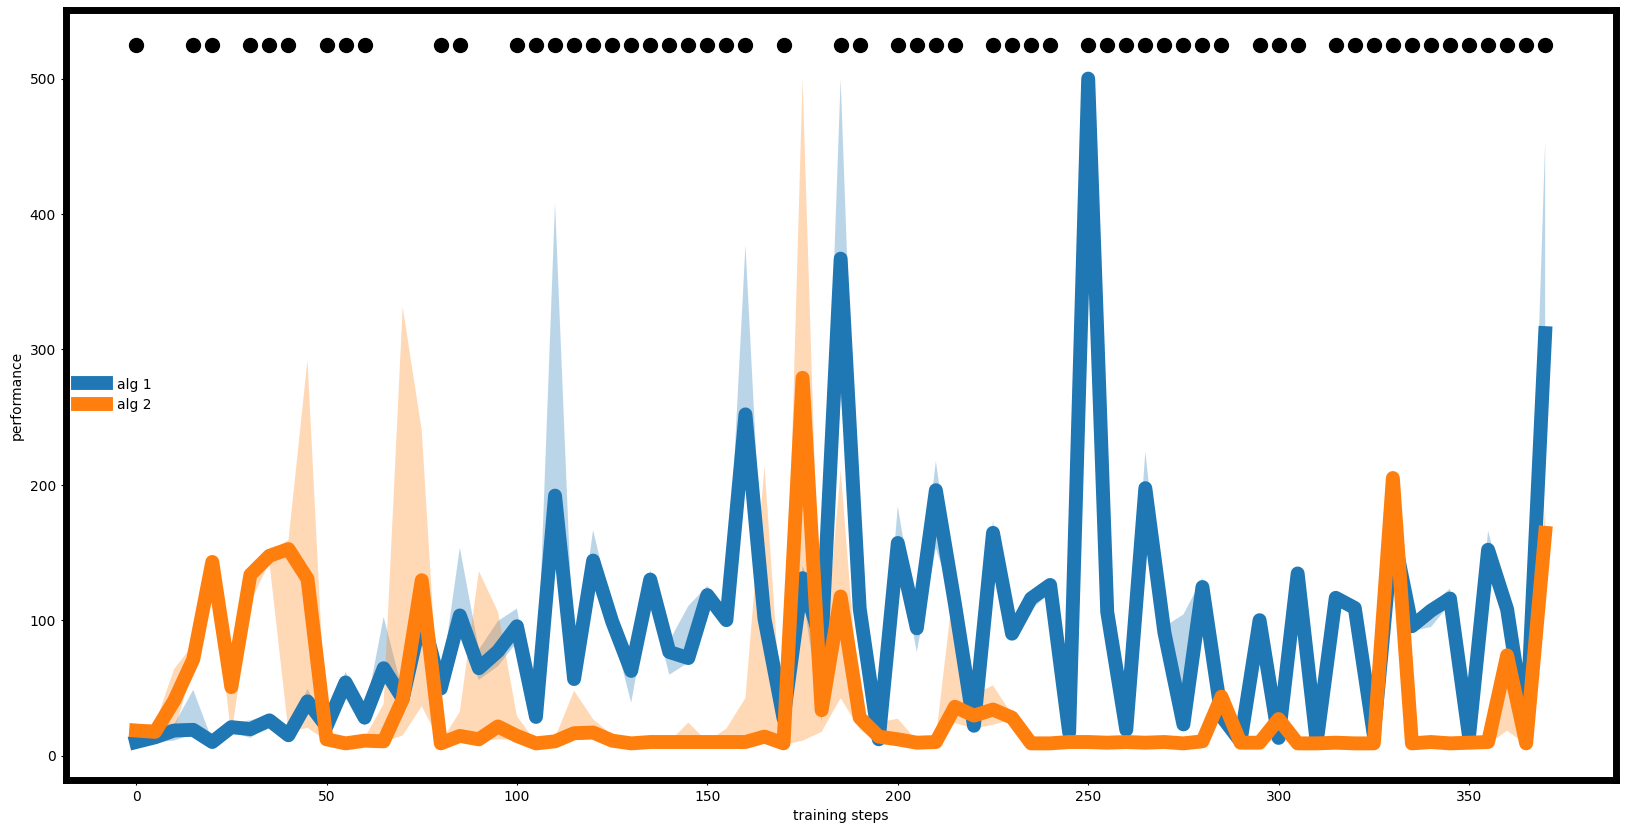

In [ ]:
from bbrl.stats import WelchTTest

WelchTTest().plot(torch.stack(dqn.eval_rewards), torch.stack(ddqn.eval_rewards))